# Меня ждут миллионы

Обучите простую модель предсказания цены акций. Используйте один из рассмотренных на лекции "Временные последовательности" алгоритмов предсказания рядов. Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1 лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модель на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью модели 
    
    Отобразите на графике предсказание модели и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [2]:
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

plt.style.use('dark_background')

In [3]:
df = pd.read_csv('./AMZN.csv')
df.head(13)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
5,1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800
6,1997-05-23,1.406250,1.520833,1.333333,1.500000,1.500000,15937200
7,1997-05-27,1.510417,1.645833,1.458333,1.583333,1.583333,8697600
8,1997-05-28,1.625000,1.635417,1.531250,1.531250,1.531250,4574400
9,1997-05-29,1.541667,1.541667,1.479167,1.505208,1.505208,3472800


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5.758000e+03
mean,340.458153,344.156408,336.344390,340.417580,340.417580,7.556094e+06
std,523.365374,528.138556,517.726971,523.140207,523.140207,7.325904e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,37.460001,38.334999,36.812499,37.562500,37.562500,3.685525e+06
50%,81.965000,83.520000,79.875000,81.599998,81.599998,5.692450e+06
75%,335.267494,337.537491,331.727501,334.290001,334.290001,8.594350e+06
max,2173.070068,2185.949951,2161.120117,2170.219971,2170.219971,1.043292e+08


In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [6]:
getMonth = lambda x: x.date().month
idxs = [(df['Date'].map(getMonth) != df['Date'].shift().map(getMonth)).cumsum()]
df2 = df.groupby(idxs).max()
df2['Date'] = df['Date'].groupby(idxs).first()
df2 = df2.set_index(['Date'])
df2.sort_index(inplace=True)
df2

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-06-02,1.708333,1.708333,1.656250,1.687500,1.687500,7807200
1997-07-01,2.520833,2.572917,2.427083,2.562500,2.562500,15517200
1997-08-01,2.375000,2.416667,2.322917,2.416667,2.416667,3588000
1997-09-02,4.645833,4.812500,4.395833,4.625000,4.625000,16938000
...,...,...,...,...,...,...
2019-12-02,1882.920044,1901.400024,1866.010010,1869.800049,1869.800049,6186600
2020-01-02,2051.469971,2055.719971,2002.270020,2008.719971,2008.719971,15567300
2020-02-03,2173.070068,2185.949951,2161.120117,2170.219971,2170.219971,9493800


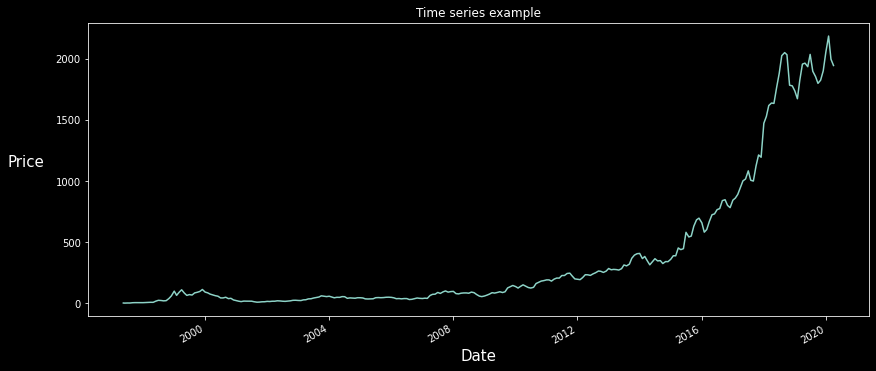

In [7]:
plt.figure(figsize=(14, 6))
plt.title('Time series example')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
df2['High'].plot();

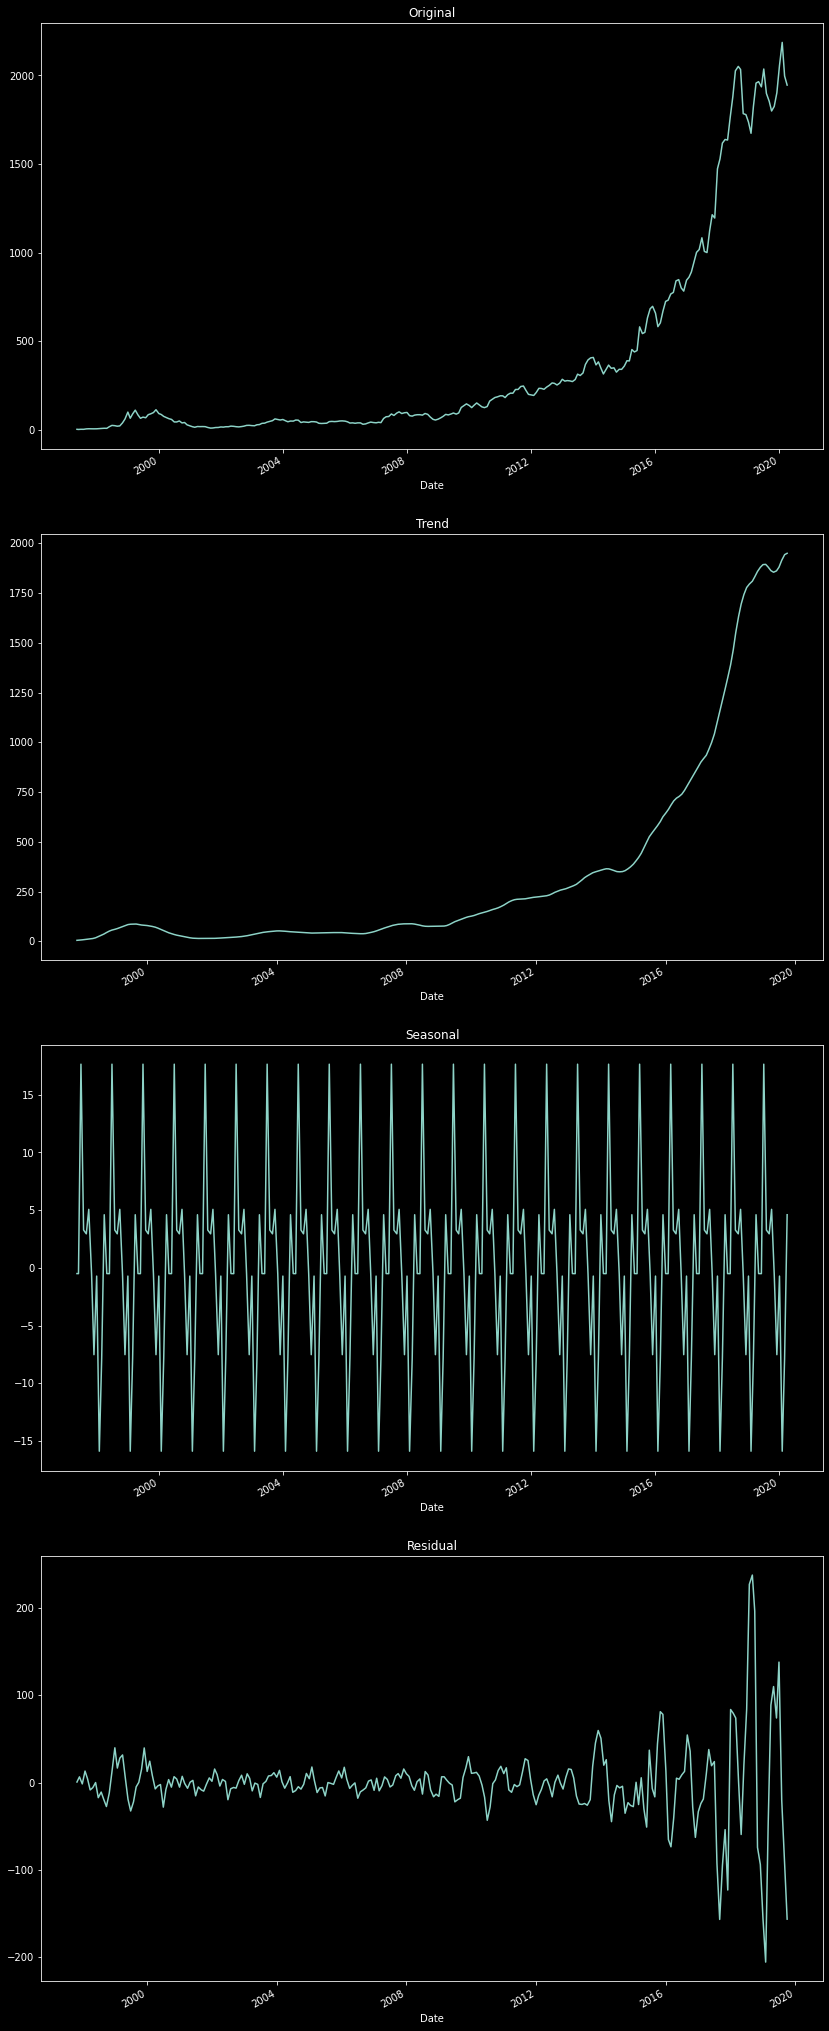

In [8]:
seasonal = 12

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df2[['High']], period=seasonal)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [9]:
X = df2.index[30:]
y = df2['High'][30:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train = pd.Series(y_train, X_train)
test = pd.Series(y_test, X_test)

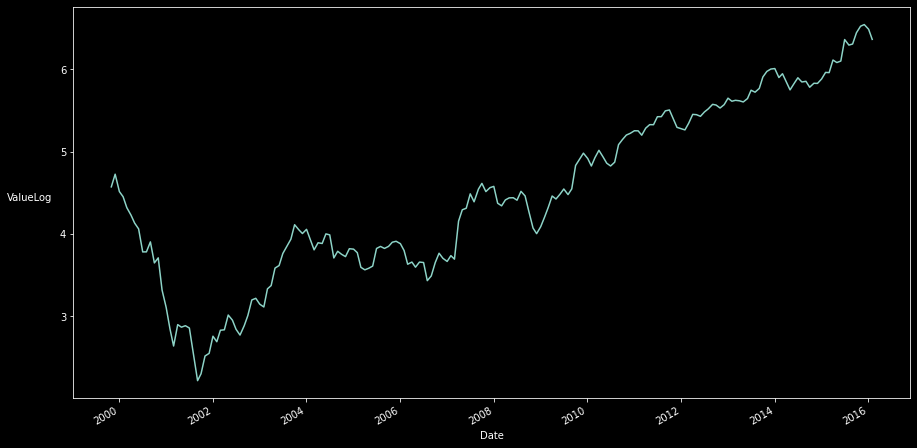

In [10]:
valueLog = np.log(train)

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLog', rotation=0, labelpad=30)
valueLog.plot();

0.0007 ? 0.05


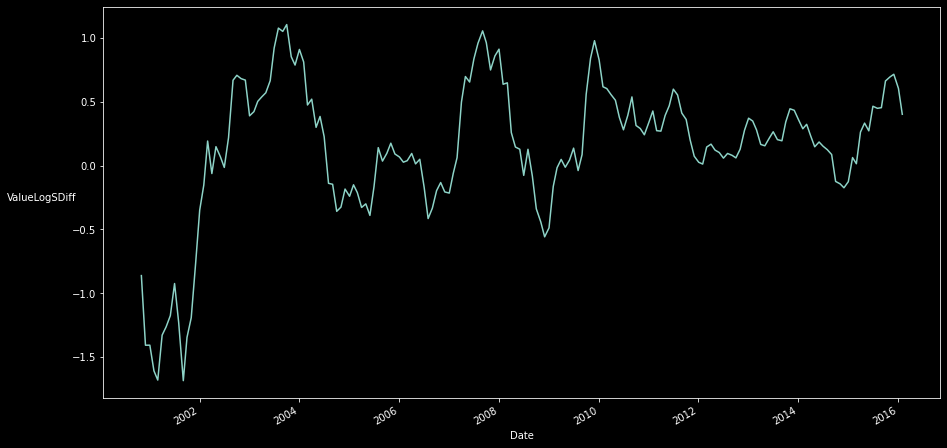

In [11]:
valueLogSDiff = valueLog - valueLog.shift(seasonal)
p_value = adfuller(valueLogSDiff[seasonal:])[1]

print(
    f'{round(p_value, 4)} ? 0.05'
)

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLogSDiff', rotation=0, labelpad=30)
valueLogSDiff.plot();

0.0 ? 0.05


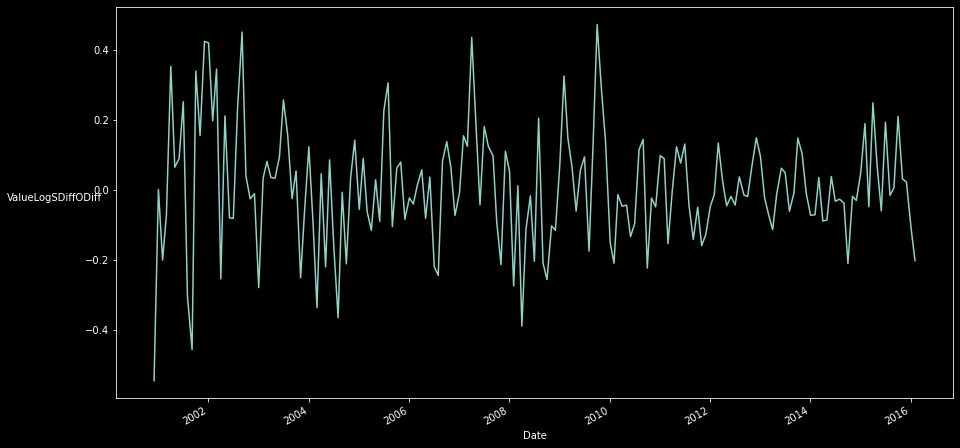

In [12]:
valueLogSDiffODiff = valueLogSDiff.diff()
p_value = adfuller(valueLogSDiffODiff[seasonal+1:])[1]

print(
    f'{round(p_value, 4)} ? 0.05'
)

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLogSDiffODiff', rotation=0, labelpad=30)
valueLogSDiffODiff.plot();

c:\users\nh5\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


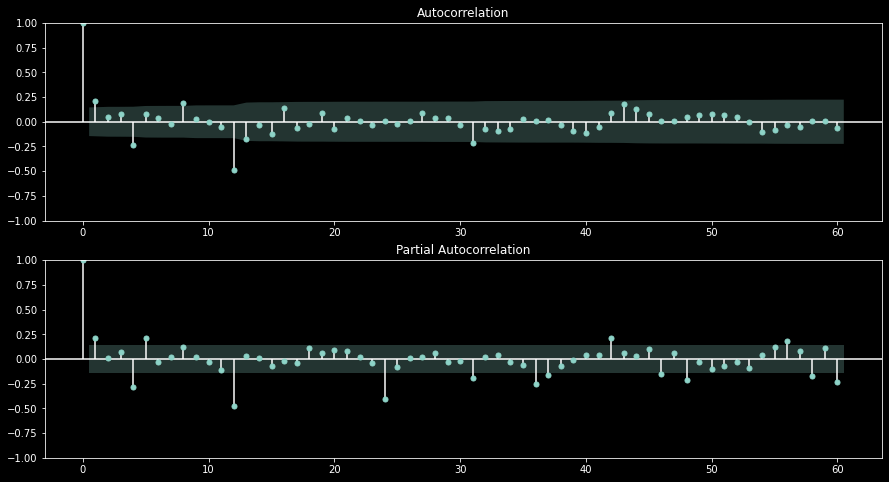

In [13]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
statsmodels.graphics.tsaplots.plot_acf(valueLogSDiffODiff[seasonal+1:], lags=60, ax=ax)

ax = plt.subplot(212)
statsmodels.graphics.tsaplots.plot_pacf(valueLogSDiffODiff[seasonal+1:], lags=60, ax=ax);

In [14]:
d=1
D=1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

In [15]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

import warnings

In [16]:
%%time
warnings.filterwarnings('ignore')
import statsmodels.api as sm


results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            valueLog,
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], seasonal)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

100%|██████████| 64/64 [11:05<00:00, 10.41s/it]

Wall time: 11min 6s


In [17]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
62  (4, 4, 4, 1) -242.052648
24  (2, 3, 3, 1) -241.792312
25  (2, 3, 3, 2) -241.535250
15  (1, 4, 4, 2) -241.112392
13  (1, 4, 3, 2) -241.066314


In [18]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 High   No. Observations:                  196
Model:             SARIMAX(4, 1, 4)x(4, 1, [1], 12)   Log Likelihood                 135.026
Date:                              Wed, 20 Oct 2021   AIC                           -242.053
Time:                                      15:04:10   BIC                           -197.120
Sample:                                           0   HQIC                          -223.839
                                              - 196                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1670      0.193     -6.059      0.000      -1.544      -0.790
ar.L2         -0.62

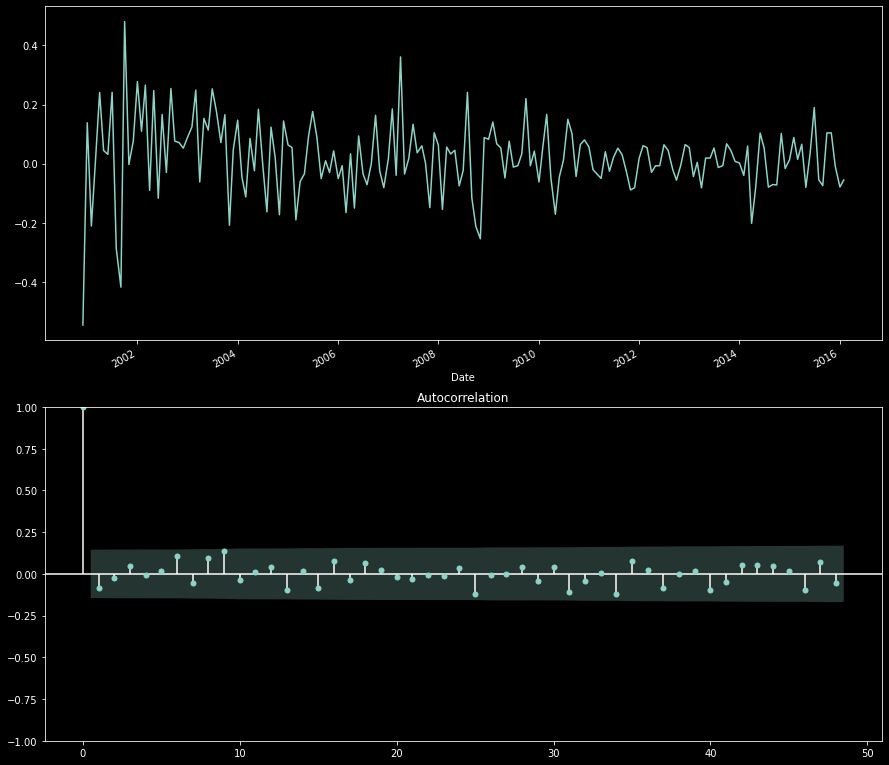

In [19]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[13:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax);

c:\users\nh5\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
c:\users\nh5\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:394: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  warnings.warn('No supported index is available. In the next'


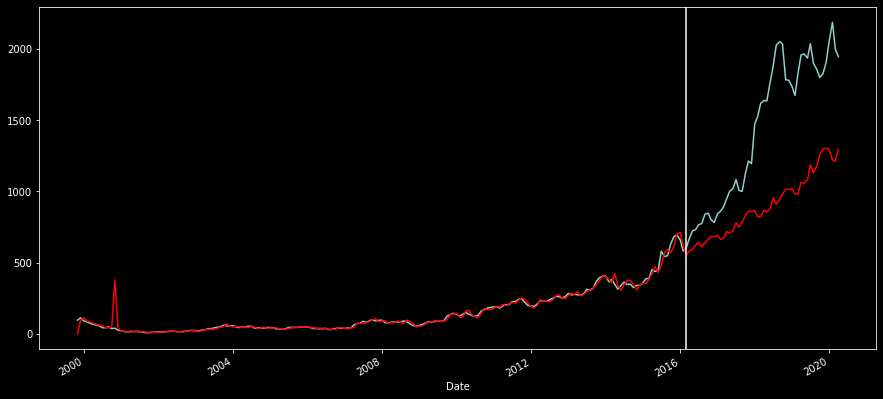

In [25]:
plt.figure(figsize=(15,7))

df2['High'][30:].plot()
y_test_predicted = np.exp(best_model.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1))
plt.plot(df2.index[30:], np.concatenate([np.exp(best_model.predict(start=0, len=X_train)), y_test_predicted]), c='r')
plt.axvline(x=X_test[0])

In [26]:
import sklearn.metrics

print('MAPE:', sklearn.metrics.mean_absolute_percentage_error(y_test, y_test_predicted))

MAPE: 0.3351048407288487
